<a href="https://colab.research.google.com/github/mchirico/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://colab.research.google.com/drive/1RZXskxLFGTMcw7Q88VwIWk7vSceGbIkf







Data From: 
[JHU CSSE](https://github.com/CSSEGISandData/COVID-19)



In [1]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  !pip install -q keras
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive





Using TensorFlow backend.


Will try to install software
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 9.5MB/s 
     |████████████████████████████████| 92kB 6.4MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.14.3 which is incompatible.


In [0]:
TMP = '/tmp/data'

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://ihmecovid19storage.blob.core.windows.net/latest/ihme-covid19.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(TMP)

In [4]:
file = !find  /tmp/data -iname '*.csv'
sdate = file[0][len(TMP)+1: len(TMP)+11]
startDate = datetime.strptime(sdate,'%Y_%m_%d')
startDate

datetime.datetime(2020, 5, 8, 0, 0)

In [5]:
p=pd.read_csv(file[0])
p.head()

,V1,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,InvVen_upper,deaths_mean,deaths_lower,deaths_upper,admis_mean,admis_lower,admis_upper,newICU_mean,newICU_lower,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper,deaths_mean_smoothed,deaths_lower_smoothed,deaths_upper_smoothed,totdea_mean_smoothed,totdea_lower_smoothed,totdea_upper_smoothed,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
0,1,Abruzzo,2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Abruzzo,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Abruzzo,2020-02-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Abruzzo,2020-02-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Abruzzo,2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reading in the data..

#### Read in Confirmed Cases

In [49]:
# 
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
d=pd.read_csv(url)
d.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136,136,136,136,136,139,141,141,141,141,141,141,145,145,145,145,145,145,149,149,151,151,151,151
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,16,16,19
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118,1213,1252,1298,1252,1416,1276,1307,1371,1389,1400,1433,1539,1575,1757,1808,1843,1924,1968,2031,2156,2173,2198,2256
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53,53,53,53,54,54,54,55,57,57,57,57,66,66,66,66,66,66,66,66,68,68,69,69


In [53]:
c=d
cols = d.columns[10:11].tolist() + d.columns[11::].tolist()
cols
c=c[cols]
c=c.set_index('Combined_Key')
c=c.diff(axis=1)
c=c.reset_index()
c

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
0,"American Samoa, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Guam, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.0,9.0,19.0,1.0,8.0,0.0,7.0,2.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0
2,"Northern Mariana Islands, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0
3,"Puerto Rico, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,0.0,136.0,23.0,38.0,60.0,47.0,63.0,42.0,63.0,109.0,6.0,20.0,51.0,69.0,25.0,50.0,95.0,39.0,46.0,-46.0,164.0,-140.0,31.0,64.0,18.0,11.0,33.0,106.0,36.0,182.0,51.0,35.0,81.0,44.0,63.0,125.0,17.0,25.0,58.0
4,"Virgin Islands, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,3.0,2.0,1.0,0.0,2.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,"Central Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3257,"Southeast Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,1.0,-2.0,1.0,2.0,-4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3258,"Southwest Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,4.0,0.0,0.0,6.0,5.0,2.0,4.0,2.0,2.0,2.0,5.0,3.0,2.0,8.0,8.0,2.0,7.0,4.0,6.0,17.0,9.0,6.0
3259,"TriCounty, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [58]:
m=pd.melt(c, id_vars=['Combined_Key'], value_vars=c.columns[2::])
m.columns = ['Country/Region', 'timeStamp',  'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Country/Region,timeStamp,value
0,"American Samoa, US",2020-01-23,0.0
1,"Guam, US",2020-01-23,0.0
2,"Northern Mariana Islands, US",2020-01-23,0.0
3,"Puerto Rico, US",2020-01-23,0.0
4,"Virgin Islands, US",2020-01-23,0.0


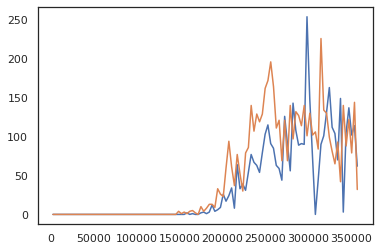

In [94]:
regions = ['Bucks, Pennsylvania, US','Montgomery, Pennsylvania, US']
for region in regions:
  z= m[m['Country/Region'].str.find(region,0)==0]
  z['value'].plot.line();

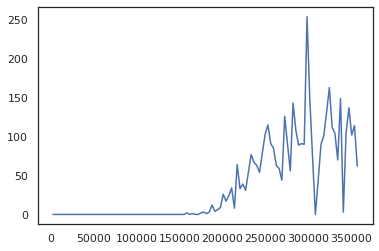

In [95]:
regions = ['Bucks, Pennsylvania, US']
for region in regions:
  m[m['Country/Region'].str.find(region,0)==0]['value'].plot.line();

In [80]:
m[m['Country/Region'].str.contains('Pennsylvania', regex=False)]['Country/Region'].tolist()

['Adams, Pennsylvania, US',
 'Allegheny, Pennsylvania, US',
 'Armstrong, Pennsylvania, US',
 'Beaver, Pennsylvania, US',
 'Bedford, Pennsylvania, US',
 'Berks, Pennsylvania, US',
 'Blair, Pennsylvania, US',
 'Bradford, Pennsylvania, US',
 'Bucks, Pennsylvania, US',
 'Butler, Pennsylvania, US',
 'Cambria, Pennsylvania, US',
 'Cameron, Pennsylvania, US',
 'Carbon, Pennsylvania, US',
 'Centre, Pennsylvania, US',
 'Chester, Pennsylvania, US',
 'Clarion, Pennsylvania, US',
 'Clearfield, Pennsylvania, US',
 'Clinton, Pennsylvania, US',
 'Columbia, Pennsylvania, US',
 'Crawford, Pennsylvania, US',
 'Cumberland, Pennsylvania, US',
 'Dauphin, Pennsylvania, US',
 'Delaware, Pennsylvania, US',
 'Elk, Pennsylvania, US',
 'Erie, Pennsylvania, US',
 'Fayette, Pennsylvania, US',
 'Forest, Pennsylvania, US',
 'Franklin, Pennsylvania, US',
 'Fulton, Pennsylvania, US',
 'Greene, Pennsylvania, US',
 'Huntingdon, Pennsylvania, US',
 'Indiana, Pennsylvania, US',
 'Jefferson, Pennsylvania, US',
 'Juniata, P

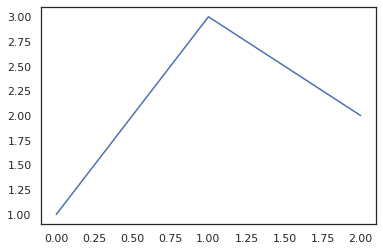

In [16]:
s = pd.Series([1, 3, 2])
s.plot.line()

### Read Deaths

In [0]:
# Deaths
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
d=pd.read_csv(url)
d.head()



,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1


In [0]:
c=d
cols = d.columns[6:7].tolist() + d.columns[12::].tolist()
cols
c=c[cols]
c=c.set_index('Province_State')
c.diff(axis=1)
#c

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
Province_State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
American Samoa,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guam,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Northern Mariana Islands,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Puerto Rico,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,3.0,1.0,3.0,3.0,2.0,1.0,2.0,1.0,9.0,6.0,3.0,2.0
Virgin Islands,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Washington,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
West Virginia,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
Wisconsin,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-1.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
d=pd.read_csv(url)
d.head()

# US counted twice: 1) County 2) State
# c = d[(d['Country/Region']=='US') & (d['Province/State'].str.contains(','))]

c = d[(d['Country/Region']=='US') & (~d['Province/State'].str.contains(',', na=False)) ]
cols = d.columns[0:1].tolist() + d.columns[4::].tolist()



c=c[cols]
c=c.set_index('Province/State')
c.diff(axis=1)

KeyError: ignored

In [0]:
c[d.columns[-10::].tolist()].diff(axis = 1)

,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
Province/State,,,,,,,,,,
NaN,NaN,5423.0,6389.0,7787.0,10571.0,9893.0,12038.0,18058.0,17821.0,19821.0


In [0]:
# Deaths
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
dt=pd.read_csv(url)
dt.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Recovered
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dr=pd.read_csv(url)
dr.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Confirmed
m=pd.melt(d, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
m.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [0]:
# deaths
mt=pd.melt(dt, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mt.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mt['timeStamp'] = mt['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mt.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


In [0]:
# Recovered
mr=pd.melt(dr, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mr.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mr['timeStamp'] = mr['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mr.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


## Summary Tables

In [0]:
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns=pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns = ns.diff(axis=1)
ns=ns.reset_index()

ns[ns['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783


In [0]:
# We both 'Province/State', 'Country/Region'
# Careful, data counted twice
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc=pd.pivot_table(m, values='value', index=['Province/State','Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc = nsc.diff(axis=1)
nsc=nsc.reset_index()

nsc[nsc['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

nsc

timeStamp,Province/State,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
0,"Adams, IN",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0,17.0,10.0,7.0
2,"Alachua, FL",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Alameda County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alaska,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Wyoming,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,8.0,4.0
315,Xinjiang,China,NaN,2.0,0.0,1.0,1.0,1.0,5.0,3.0,1.0,3.0,1.0,3.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,4.0,6.0,4.0,4.0,2.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,"Yolo County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317,Yunnan,China,NaN,1.0,3.0,6.0,5.0,10.0,18.0,11.0,15.0,13.0,10.0,12.0,12.0,5.0,6.0,5.0,5.0,0.0,3.0,8.0,4.0,1.0,2.0,6.0,6.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [0]:
# Deaths
nt=pd.pivot_table(mt, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst=pd.pivot_table(mt, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst = nst.diff(axis=1)
nst=nst.reset_index()
nst.columns
nst[nst[nst.columns[44]]>0]

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
28,China,NaN,1.0,8.0,16.0,14.0,26.0,49.0,2.0,38.0,42.0,46.0,102.0,64.0,66.0,72.0,70.0,85.0,87.0,100.0,107.0,100.0,5.0,252.0,152.0,142.0,103.0,98.0,139.0,113.0,122.0,0.0,205.0,2.0,150.0,70.0,52.0,29.0,44.0,47.0,35.0,42.0,33.0,36.0,32.0,29.0,28.0,28.0,23.0,16.0,22.0,11.0,8.0,13.0,10.0,14.0,13.0,11.0
49,France,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,8.0,0.0,14.0,15.0,0.0,31.0,12.0,0.0,57.0,0.0,0.0
66,Iran,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,3.0,4.0,4.0,3.0,7.0,8.0,9.0,11.0,12.0,11.0,15.0,15.0,17.0,21.0,49.0,43.0,54.0,63.0,75.0,85.0,97.0,113.0,129.0,135.0,147.0
70,Italy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,4.0,8.0,5.0,18.0,27.0,28.0,41.0,49.0,36.0,133.0,97.0,168.0,196.0,0.0,439.0,175.0,368.0,349.0,345.0,475.0
129,Spain,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,7.0,11.0,7.0,19.0,1.0,78.0,62.0,94.0,53.0,191.0,90.0
134,Switzerland,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,7.0,2.0,1.0,0.0,13.0,1.0
143,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,6.0,8.0,4.0,7.0,7.0,9.0,22.0,23.0,10.0
146,United Kingdom,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,13.0,0.0,35.0,0.0,16.0


In [0]:

ns.head()

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
0,Afghanistan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0
1,Albania,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0
2,Algeria,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,0.0,5.0,0.0,2.0,1.0,0.0,0.0,4.0,2.0,11.0,11.0,6.0,6.0,14.0
3,Andorra,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,37.0,0.0
4,Antigua and Barbuda,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
ns[ns['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,NaN,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,36.0,0.0,6.0,1.0,2.0,8.0,6.0,24.0,20.0,31.0,68.0,45.0,140.0,116.0,65.0,376.0,322.0,382.0,516.0,548.0,772.0,1133.0,1789.0,1362.0


In [0]:
nm=pd.melt(nsc, id_vars=['Province/State','Country/Region'], value_vars=ns.columns[1::])
nm.head(7)

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,Alabama,US,2020-01-22,NaN
2,"Alachua, FL",US,2020-01-22,NaN
3,"Alameda County, CA",US,2020-01-22,NaN
4,Alaska,US,2020-01-22,NaN
5,Alberta,Canada,2020-01-22,NaN
6,Anhui,China,2020-01-22,NaN


In [0]:
nm[nm['Country/Region']=='US']

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,Alabama,US,2020-01-22,NaN
2,"Alachua, FL",US,2020-01-22,NaN
3,"Alameda County, CA",US,2020-01-22,NaN
4,Alaska,US,2020-01-22,NaN
...,...,...,...,...
18175,"Williamson County, TN",US,2020-03-18,0.0
18176,Wisconsin,US,2020-03-18,20.0
18177,"Worcester, MA",US,2020-03-18,0.0
18178,Wyoming,US,2020-03-18,4.0


In [0]:
t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
t[t.columns[1::]]

,Country/Region,timeStamp,value
0,US,2020-01-22,NaN
2,US,2020-01-22,NaN
3,US,2020-01-22,NaN
7,US,2020-01-22,NaN
8,US,2020-01-22,NaN
...,...,...,...
18172,US,2020-03-18,0.0
18174,US,2020-03-18,0.0
18175,US,2020-03-18,0.0
18177,US,2020-03-18,0.0


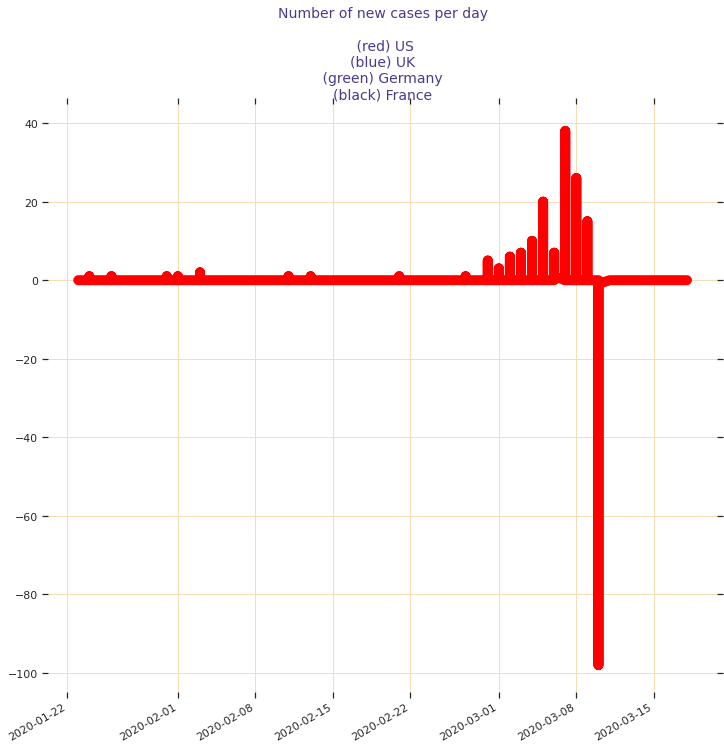

In [0]:

t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
# Adjust for extra col
t = t[t.columns[1::]]
t2=nm[nm['Country/Region']=='UK']
t3=nm[nm['Country/Region']=='Germany']
t4=nm[nm['Country/Region']=='France']



from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['value'],color = 'red',linewidth=10)
#ax.plot(t2['timeStamp'],t2['value'],color = 'blue')
#ax.plot(t3['timeStamp'],t3['value'],color = 'green')
#ax.plot(t3['timeStamp'],t4['value'],color = 'black')


ax.set_title("""Number of new cases per day
\n (red) US\n(blue) UK\n (green) Germany \n(black) France""", 
             fontsize=14, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [0]:

mySet = list(nm[nm['value'] > 50]['Country/Region'].drop_duplicates())

t = nm[nm['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Australia,Canada,China,Cruise Ship,Denmark,France,Netherlands,US,United Kingdom
0,2020-01-22,5.0,2.0,4961.0,0.0,0.0,4.0,0.0,4.0,0.0
1,2020-01-29,8.0,2.0,18198.0,0.0,0.0,2.0,0.0,6.0,2.0
2,2020-02-05,2.0,3.0,20679.0,135.0,0.0,5.0,0.0,1.0,6.0
3,2020-02-12,0.0,1.0,29825.0,407.0,0.0,1.0,0.0,1.0,1.0
4,2020-02-19,7.0,3.0,3543.0,149.0,0.0,2.0,0.0,38.0,4.0
5,2020-02-26,17.0,19.0,2507.0,15.0,6.0,190.0,24.0,67.0,38.0
6,2020-03-04,68.0,49.0,626.0,-10.0,258.0,1588.0,358.0,841.0,333.0
7,2020-03-11,345.0,399.0,171.0,0.0,760.0,5907.0,1329.0,5462.0,1576.0
8,2020-03-18,116.0,179.0,44.0,16.0,91.0,1406.0,347.0,1362.0,682.0


In [0]:
# Deaths
nmt=pd.melt(nst, id_vars=['Country/Region'], value_vars=ns.columns[1::])



mySet = list(nmt[nmt['value'] > 1]['Country/Region'].drop_duplicates())

t = nmt[nmt['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Algeria,Australia,Austria,Belgium,Brazil,Canada,China,Cruise Ship,Ecuador,Egypt,France,Germany,Greece,Iceland,Indonesia,Iran,Iraq,Italy,Japan,"Korea, South",Lebanon,Malaysia,Netherlands,Norway,Philippines,San Marino,Spain,Sweden,Switzerland,US,United Kingdom
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-12,0.0,0.0,0.0,0.0,0.0,0.0,891.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-19,0.0,0.0,0.0,0.0,0.0,0.0,662.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2020-02-26,0.0,1.0,0.0,0.0,0.0,0.0,282.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,61.0,0.0,69.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0
6,2020-03-04,0.0,2.0,0.0,0.0,0.0,1.0,192.0,0.0,0.0,1.0,29.0,2.0,0.0,0.0,0.0,214.0,7.0,552.0,4.0,26.0,1.0,0.0,4.0,0.0,0.0,1.0,34.0,0.0,3.0,21.0,6.0
7,2020-03-11,4.0,2.0,3.0,10.0,1.0,4.0,91.0,1.0,2.0,3.0,115.0,22.0,5.0,1.0,5.0,697.0,4.0,1872.0,19.0,27.0,2.0,2.0,39.0,3.0,11.0,5.0,498.0,7.0,24.0,80.0,50.0
8,2020-03-18,3.0,1.0,1.0,4.0,2.0,3.0,11.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,14.0,147.0,1.0,475.0,0.0,3.0,0.0,0.0,15.0,3.0,7.0,4.0,90.0,3.0,1.0,10.0,16.0


In [0]:
nst[nst['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00
143,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,6.0,8.0,4.0,7.0,7.0,9.0,22.0,23.0,10.0


In [0]:
mt[(mt['Country/Region']=='US') ]['Province/State'].unique

<bound method Series.unique of 225      NaN
478      NaN
731      NaN
984      NaN
1237     NaN
        ... 
15911    NaN
16164    NaN
16417    NaN
16670    NaN
16923    NaN
Name: Province/State, Length: 67, dtype: object>